In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay


In [3]:
# Define file names and column names
pred_csv = "predicted_af_0.csv"
pred_id_col = "exam_ids"
pred_class_col = "predicted_class"
pred_prob = "prob_class"

true_csv = "new_hdf5_exams_info.csv"
true_id_col = "id_exam"
true_class_col = "exam_class"

In [4]:
# Read predicted csv file
pred_df = pd.read_csv(pred_csv, index_col= pred_id_col)
#pred_ids = pred_df[pred_id_col]
pred_index = pred_df.index
pred_df.head(10)

,exam_ids.1,predicted_class,prob_class1,prob_class2,prob_class3
exam_ids,,,,,
2936711,2936711,1.0,0.776616,0.197865,0.025519
223229,223229,1.0,0.825182,0.150186,0.024632
625648,625648,1.0,0.827402,0.148043,0.024555
1281753,1281753,1.0,0.801250,0.162540,0.036209
758600,758600,1.0,0.822250,0.153210,0.024540
55018,55018,1.0,0.818901,0.157430,0.023669
834147,834147,1.0,0.829654,0.144710,0.025636
183548,183548,1.0,0.820060,0.155114,0.024825
61670,61670,1.0,0.808981,0.165816,0.025203


In [5]:
pred_index.values[:10]

array([2936711,  223229,  625648, 1281753,  758600,   55018,  834147,
        183548,   61670,  534471], dtype=int64)

In [6]:
# Read exams info file
exams_df = pd.read_csv(true_csv, index_col = true_id_col)
exams_df.head(10)

,Unnamed: 0,id_patient,age,sex,AF,exam_class,split
id_exam,,,,,,,
2936711,2,94856,67,F,0,1,test
223229,5,444383,78,F,0,1,train
625648,7,585008,17,F,0,1,test
1281753,9,590301,19,F,0,1,train
758600,17,835958,83,M,0,1,test
55018,18,956009,69,F,0,1,test
834147,24,20849,56,F,0,1,train
183548,25,309816,44,F,0,1,train
61670,43,555068,44,F,0,1,train


In [7]:
# predicted file stats
pred_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,22047.0,1.387562e+06,1.204550e+06,64.000000,440976.000000,960476.000000,2.664513e+06,4.416611e+06
predicted_class,22047.0,1.000045e+00,6.734808e-03,1.000000,1.000000,1.000000,1.000000e+00,2.000000e+00
prob_class1,22047.0,8.157937e-01,4.097406e-02,0.471345,0.801392,0.816932,8.262816e-01,1.000000e+00
prob_class2,22047.0,1.603695e-01,3.748117e-02,0.000000,0.149091,0.157893,1.725310e-01,5.237197e-01
prob_class3,22047.0,2.383680e-02,5.544450e-03,0.000000,0.024137,0.024596,2.512718e-02,3.620929e-02


In [8]:
# true exams file stats
exams_df = exams_df.reindex(pred_index, fill_value=False, copy=True) # Keep ids that are in pred_csv file
print(exams_df.isnull().sum() ==0) # It should print True, all ids in pred_csv should be in true_csv
exams_df.describe().transpose()

Unnamed: 0    True
id_patient    True
age           True
sex           True
AF            True
exam_class    True
split         True
dtype: bool


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,22047.0,35010.576450,20117.649869,2.0,17522.5,35132.0,52241.5,69995.0
id_patient,22047.0,588135.908060,569235.443942,4.0,98324.0,337351.0,1064715.5,1773272.0
age,22047.0,58.201887,18.020018,17.0,45.0,61.0,74.0,91.0
AF,22047.0,0.064861,0.246287,0.0,0.0,0.0,0.0,1.0
exam_class,22047.0,1.100422,0.354829,1.0,1.0,1.0,1.0,3.0


In [9]:
exams_df[true_class_col].value_counts()

1    20225
2     1430
3      392
Name: exam_class, dtype: int64

In [10]:
pred_df[pred_class_col].value_counts()

1.0    22046
2.0        1
Name: predicted_class, dtype: int64

In [11]:
pred_values = np.array(pred_df[pred_class_col], dtype=np.int64)
true_values = np.array(exams_df[true_class_col])
prob_classes = np.array(pred_df[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]])
print(len(pred_values) == len(true_values))


True


In [12]:
def get_perform_metrics(true_val, pred_val):
    """ A method to check performance metrics: accuracy, precision, recall, F1-score and confusion matrix."""
    
    target_names = ['class 1', 'class 2', 'class 3']   # 3 classes 
    
    # Accuracy on test data
    print("\nAccuracy on test data.\n")
    accuracy = np.mean(pred_val == true_val)
    print ("Accuracy: ", accuracy)

    #Confusion matrix
    print ("\nConfusion matrix, DNN model\n")
    print(pd.crosstab(true_val, pred_val, rownames=['True_value'], colnames=['Predicted'], margins=True))
    
    #Classification report    
    print("\nTest report:")
    print(classification_report(true_val, pred_val, target_names=target_names, zero_division=0))
    
    # plots class distribution on test data, true and predicted values
    fig = plt.figure(figsize=(10, 14))
    df_y_test = pd.DataFrame(true_val)[0].value_counts()
    df_y_pred = pd.DataFrame(pred_val)[0].value_counts()
    ax1 = plt.subplot(2, 2, 1)
    df_y_test.plot(kind='bar')
    plt.title('True values distribution')
    plt.xlabel('AF class')
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    df_y_pred.plot(kind='bar')
    plt.title('Predicted values distribution')
    plt.xlabel('AF class')
    
    """Plot confusion matrice of the model"""
    
    #fig2 = plt.figure(figsize=(6, 6))
    ax3 = plt.subplot(2, 1, 2)
    ConfusionMatrixDisplay.from_predictions(true_val, pred_val, cmap = plt.cm.YlGnBu, ax=ax3)  

    ax3.set_title("Confusion Matrix: DNN model", fontsize = 16)
    ax3.set_xlabel('Predicted labels', fontsize = 15)
    ax3.set_ylabel('True labels', fontsize = 15)
    '''
    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font) 
    '''
    plt.show()



def plot_confusion_matrices(y_true, y_pred):
    """Plot confusion matrices of differet models"""
    
    fig2 = plt.figure(figsize=(6, 4))
    ax = plt.subplot(1, 1, 1)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap = plt.cm.YlGnBu, ax=ax)  

    ax.set_title("Confusion Matrix: DNN model", fontsize = 16)
    ax.set_xlabel('Predicted labels', fontsize = 15)
    ax.set_ylabel('True labels', fontsize = 15)
    '''
    font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
    plt.rc('font', **font) 
    '''
    plt.show()

plot_confusion_matrices(true_values, pred_values)



Accuracy on test data.

Accuracy:  0.9174037283984215

Confusion matrix, DNN model

Predicted       1  2    All
True_value                 
1           20225  0  20225
2            1429  1   1430
3             392  0    392
All         22046  1  22047

Test report:
              precision    recall  f1-score   support

     class 1       0.92      1.00      0.96     20225
     class 2       1.00      0.00      0.00      1430
     class 3       0.00      0.00      0.00       392

    accuracy                           0.92     22047
   macro avg       0.64      0.33      0.32     22047
weighted avg       0.91      0.92      0.88     22047



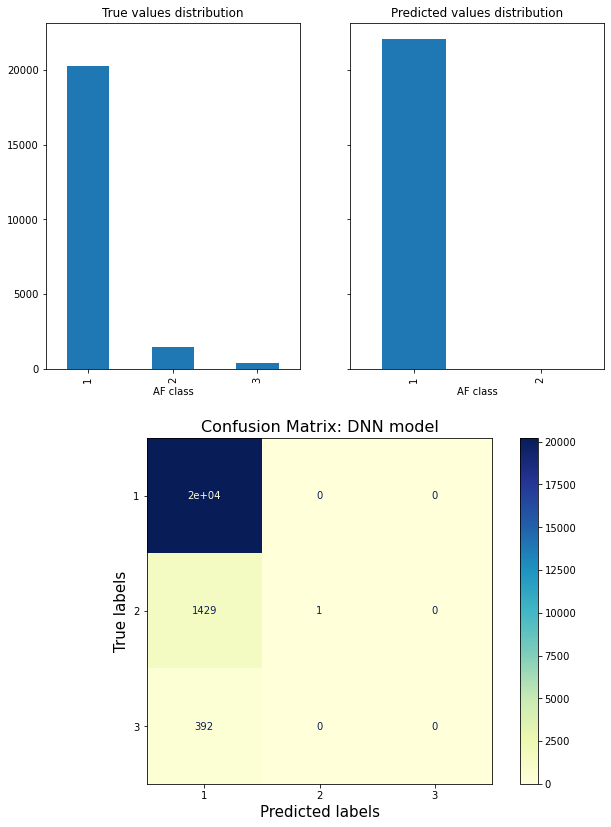

In [13]:
get_perform_metrics(true_values, pred_values)

### Plotting ROC Curve, get AUC Score

In [14]:

def plot_roc_curve(true_values, prob_classes):
    """Plot ROC curve for each class and get AUC scores"""

    fpr = {}
    tpr = {}
    thresh ={}

    n_classes = 3
    auc_scores = []

    random_probs = [0 for i in range(len(true_values))]
    rand_fpr, rand_tpr, _ = roc_curve(true_values, random_probs, pos_label=1)

    for i in range(n_classes):    
        fpr[i], tpr[i], thresh[i] = roc_curve(true_values, prob_classes[:,i], pos_label=i+1)
        auc_scores.append(auc(fpr[i], tpr[i]))
    
    # plotting
    fig = plt.figure(figsize=(8, 6))
    plt.style.use('seaborn')
    plt.plot(fpr[0], tpr[0], label='Class 1 vs Rest, AUC = {:.3f}'.format(auc_scores[0]))
    plt.plot(fpr[1], tpr[1], label='Class 2 vs Rest, AUC = {:.3f}'.format(auc_scores[1]))
    plt.plot(fpr[2], tpr[2], label='Class 3 vs Rest, AUC = {:.3f}'.format(auc_scores[2]))
    plt.plot(rand_fpr, rand_tpr, linestyle='--', color='black')
    plt.title('Multiclass ROC curve', fontsize = 16)
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive rate', fontsize = 14)
    plt.legend(loc='best', fontsize = 12)
    #plt.savefig('Multiclass ROC',dpi=300); 
    plt.show()

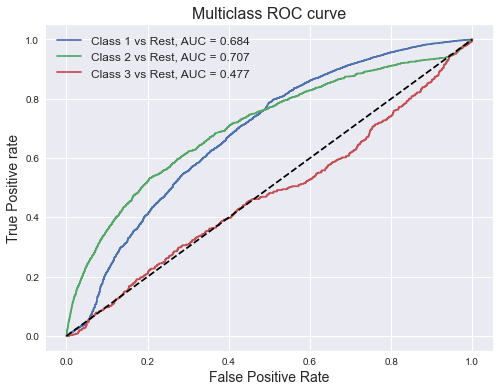

In [15]:
# roc curve for classes
plot_roc_curve(true_values, prob_classes)

In [16]:
overall_auc_score = roc_auc_score(true_values, prob_classes, multi_class='ovr')
overall_auc_score

0.6223965263898179

In [17]:
# One hot encoding
encoder = OneHotEncoder()
n_classes = 3


In [18]:

def overall_roc_curve(true_values, prob_classes):
    """plot the overall ROC curve for all classes"""
    
    Y_onehot = encoder.fit_transform(true_values[:, np.newaxis]).toarray()
    ov_fpr, ov_tpr, ov_threshold = roc_curve(Y_onehot.ravel(), prob_classes.ravel())

    plt.figure(figsize=(8, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(ov_fpr, ov_tpr, label='AUC = {:.3f}'.format(auc(ov_fpr, ov_tpr)))
    plt.xlabel('False positive rate', fontsize = 13)
    plt.ylabel('True positive rate', fontsize = 13)
    plt.title('ROC curve', fontsize = 16)
    plt.legend(loc='best', fontsize = 13)
    plt.show()

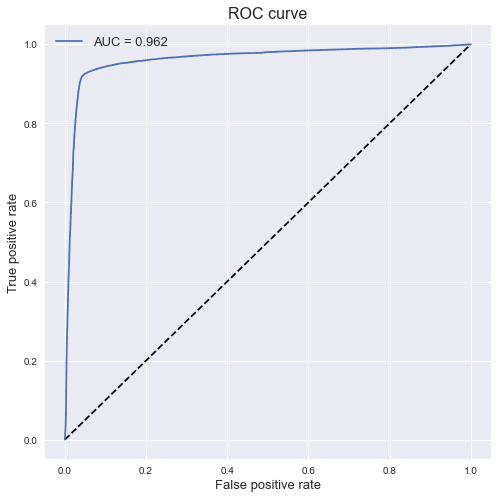

In [19]:
# Plotting the overall ROC curve
overall_roc_curve(true_values, prob_classes)

### Plotting the Precision-Recall curve

In [20]:
# Precision, Recall and Average Precision Score

def get_precision_recall_values(true_values, prob_classes):
    """Get values for precision, recall and average precision score"""
    
    # Use label_binarize to make multi-label like variable
    true_onehot = label_binarize(true_values, classes=[1, 2, 3])

    # For each class get performance data
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(true_onehot[:, i], prob_classes[:, i])
        average_precision[i] = average_precision_score(true_onehot[:, i], prob_classes[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], t_ = precision_recall_curve(true_onehot.ravel(), prob_classes.ravel())
    average_precision["micro"] = average_precision_score(true_onehot, prob_classes, average="micro")
    
    return precision, recall, average_precision


In [21]:
# Plot the micro-averaged Precision-Recall curve

def plot_micro_averaged_prcurve(precision, recall, average_precision):
    """Plot the micro-averaged Precision-Recall curve"""
    
    
    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    
    display.plot()
    _ = display.ax_.set_title("Precision-Recall, Micro-averaged over all classes", fontsize = 14)
    _ = display.ax_.set_xlabel("Recall", fontsize = 13)
    _ = display.ax_.set_ylabel("precision", fontsize = 13)

In [22]:
# Plot Precision-Recall curve for each class and iso-f1 curves
from itertools import cycle
def plot_precision_recall_curve(precision, recall, average_precision):
    """Plot Precision-Recall curve for each class and iso-f1 curves"""

    # setup plot details
    colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

    #plt.style.use('seaborn')
    plt.style.use('default')
    _, ax = plt.subplots(figsize=(7, 8))

    f_scores = np.linspace(0.2, 0.8, num=4)
    lines, labels = [], []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
        plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02), fontsize = 12)

    display = PrecisionRecallDisplay(
        recall=recall["micro"],
        precision=precision["micro"],
        average_precision=average_precision["micro"],
    )
    display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

    for i, color in zip(range(n_classes), colors):
        display = PrecisionRecallDisplay(
            recall=recall[i],
            precision=precision[i],
            average_precision=average_precision[i],
        )
        display.plot(ax=ax, name=f"Precision-recall for class {i+1}", color=color)

    # add the legend for the iso-f1 curves
    handles, labels = display.ax_.get_legend_handles_labels()
    handles.extend([l])
    labels.extend(["iso-f1 curves"])
    # set the legend and the axes
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(handles=handles, labels=labels, loc="best", fontsize = 12)
    ax.set_title("Precision-Recall curve for multi-class", fontsize = 14)
    plt.rc('font', size=12)
    #ax.xaxis.label.set_size(12)
    #ax.yaxis.label.set_size(12)
    #ax.tick_params(axis='both', labelsize=12)

    plt.show()


In [23]:
precision, recall, average_precision = get_precision_recall_values(true_values, prob_classes)

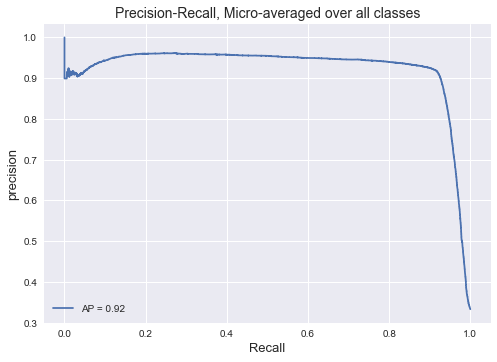

In [24]:
# Plot the micro-averaged Precision-Recall curve
plot_micro_averaged_prcurve(precision, recall, average_precision)

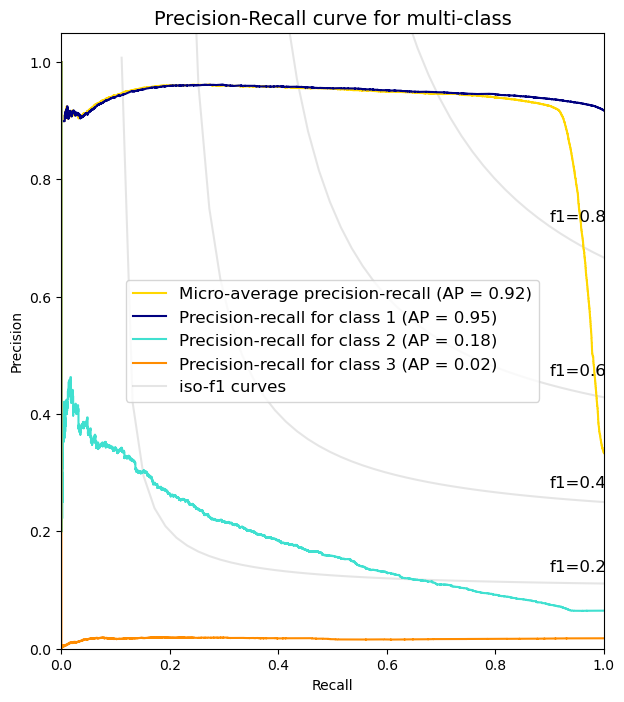

In [25]:
# Plot Precision-Recall curve for each class and iso-f1 curves
plot_precision_recall_curve(precision, recall, average_precision)

### Performance of the model trained with weighted loss

In [26]:
# Get true values, predicted values and class probabilities

pred_csv_weight = "predicted_af_weight.csv"
pred_df_w = pd.read_csv(pred_csv_weight, index_col= pred_id_col)
pred_index_w = pred_df_w.index
exams_df_w = exams_df.reindex(pred_index_w, fill_value=False, copy=True) # Keep ids that are in pred_csv file
pred_values_w = np.array(pred_df_w[pred_class_col], dtype=np.int64)
true_values_w = np.array(exams_df_w[true_class_col])
prob_classes_w = np.array(pred_df_w[[pred_prob + str(1), pred_prob + str(2), pred_prob + str(3)]])
print(len(pred_values_w) == len(true_values_w))
pred_df_w[pred_class_col].value_counts()

True


1.0    22047
Name: predicted_class, dtype: int64


Accuracy on test data.

Accuracy:  0.9173583707533904

Confusion matrix, DNN model

Predicted       1    All
True_value              
1           20225  20225
2            1430   1430
3             392    392
All         22047  22047

Test report:
              precision    recall  f1-score   support

     class 1       0.92      1.00      0.96     20225
     class 2       0.00      0.00      0.00      1430
     class 3       0.00      0.00      0.00       392

    accuracy                           0.92     22047
   macro avg       0.31      0.33      0.32     22047
weighted avg       0.84      0.92      0.88     22047



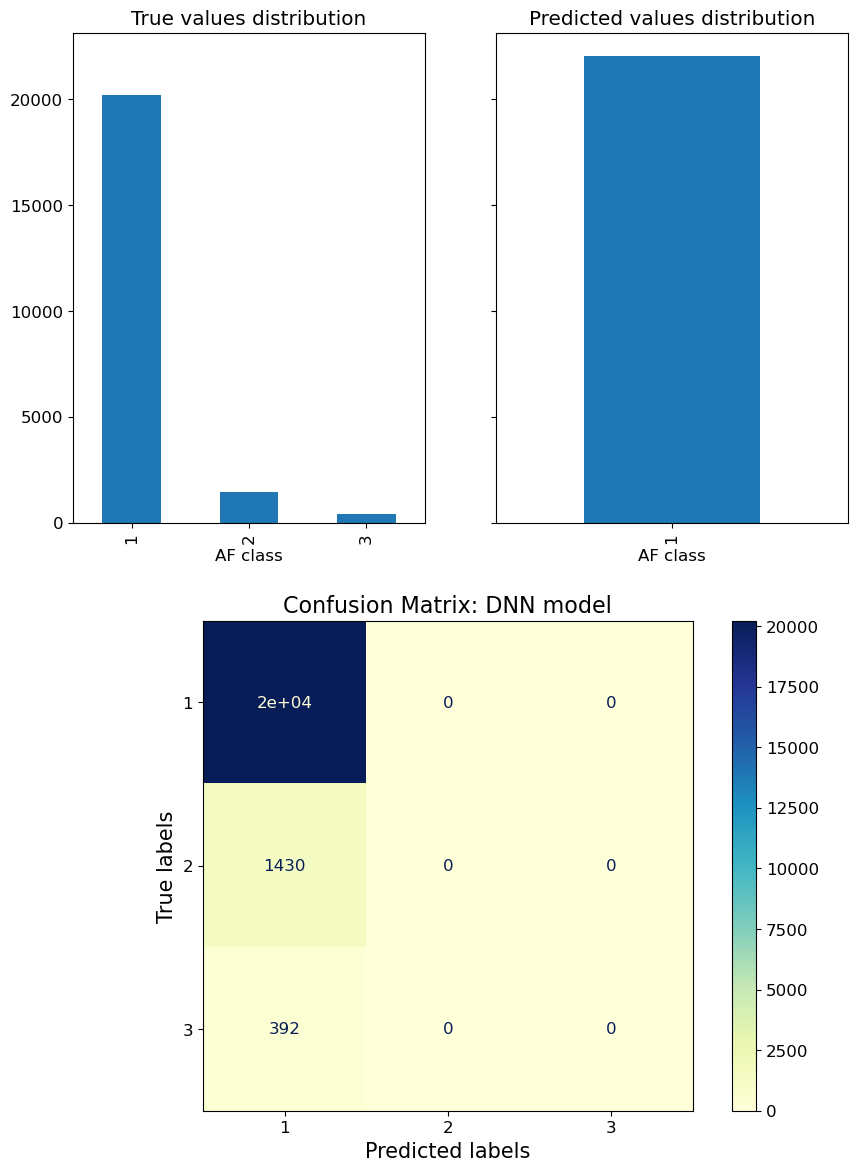

In [27]:
# Get performance metrics for the model with weights
get_perform_metrics(true_values_w, pred_values_w)

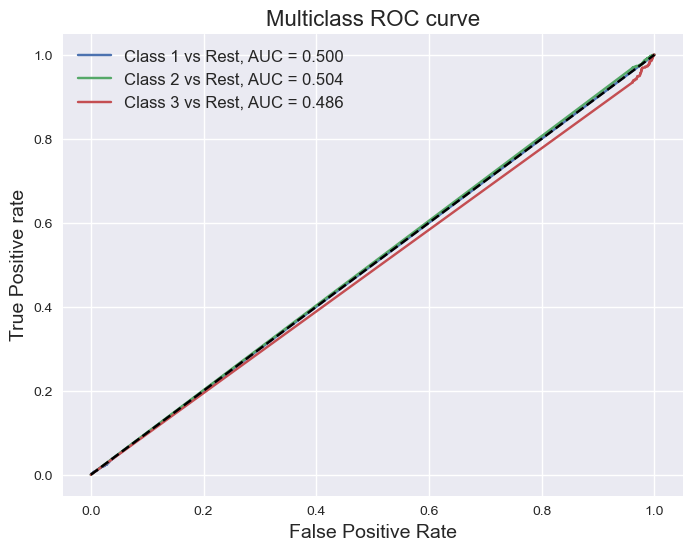

In [28]:
# roc curve for each class, model with weights
plot_roc_curve(true_values_w, prob_classes_w)

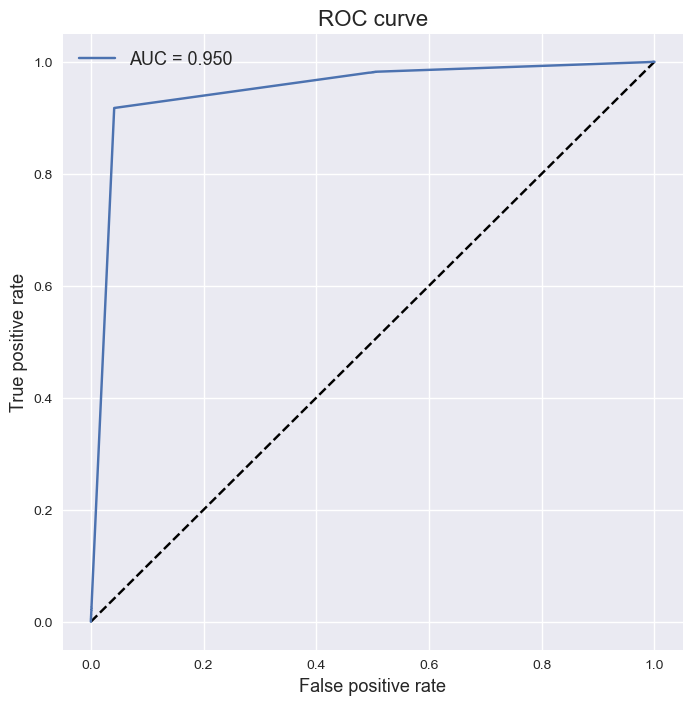

In [29]:
# Plotting the overall ROC curve, model with weights
overall_roc_curve(true_values_w, prob_classes_w)

In [30]:
# Get values for precision, recall and average precision score, , model with weights
precision_w, recall_w, average_precision_w = get_precision_recall_values(true_values_w, prob_classes_w)


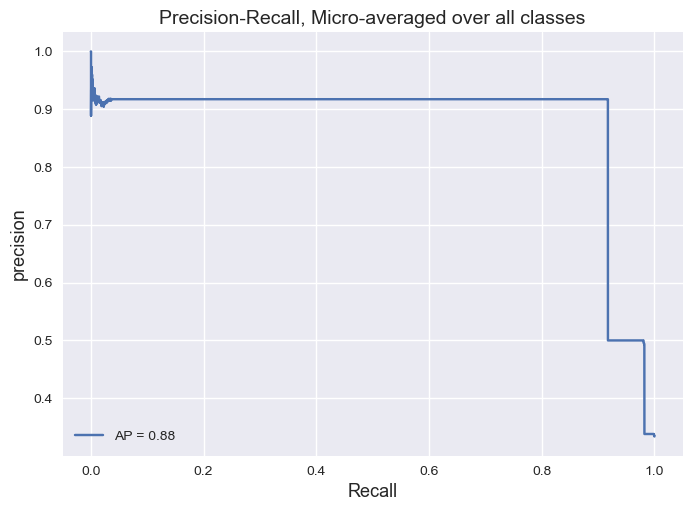

In [31]:
# Plot the micro-averaged Precision-Recall curve, , model with weights
plot_micro_averaged_prcurve(precision_w, recall_w, average_precision_w)

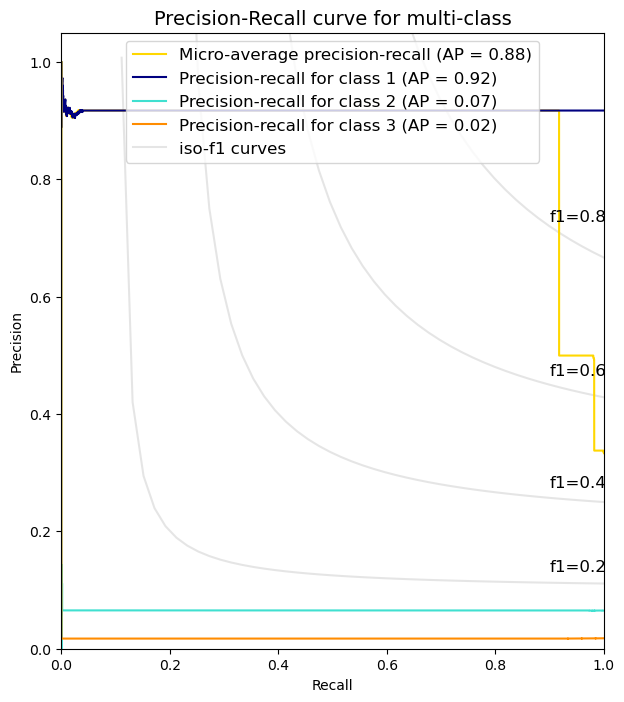

In [32]:
# Plot Precision-Recall curve for each class and iso-f1 curves,, model with weights
plot_precision_recall_curve(precision_w, recall_w, average_precision_w)

In [33]:
pred_df_w.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,22047.0,1.387562e+06,1.204550e+06,6.400000e+01,440976.000000,960476.000000,2.664513e+06,4.416611e+06
predicted_class,22047.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00
prob_class1,22047.0,5.683540e-01,2.233785e-02,5.665300e-01,0.566574,0.566574,5.665742e-01,1.000000e+00
prob_class2,22047.0,3.104998e-01,1.553310e-02,1.808731e-10,0.311691,0.311691,3.116913e-01,3.130268e-01
prob_class3,22047.0,1.211461e-01,6.850862e-03,2.095296e-14,0.121734,0.121734,1.217345e-01,1.217345e-01


In [34]:
pred_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
exam_ids.1,22047.0,1.387562e+06,1.204550e+06,64.000000,440976.000000,960476.000000,2.664513e+06,4.416611e+06
predicted_class,22047.0,1.000045e+00,6.734808e-03,1.000000,1.000000,1.000000,1.000000e+00,2.000000e+00
prob_class1,22047.0,8.157937e-01,4.097406e-02,0.471345,0.801392,0.816932,8.262816e-01,1.000000e+00
prob_class2,22047.0,1.603695e-01,3.748117e-02,0.000000,0.149091,0.157893,1.725310e-01,5.237197e-01
prob_class3,22047.0,2.383680e-02,5.544450e-03,0.000000,0.024137,0.024596,2.512718e-02,3.620929e-02
